# Aerial Cactus Identification

Kaggle competition at: https://www.kaggle.com/c/aerial-cactus-identification

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from sklearn import svm
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/shm/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Inspect data

Load and view a data example

Data consists of a csv file with filenames and a has_cactus flag + a folder with all the pictures.

In [2]:
DATA_PATH = 'data'

def image_path(id_, path='train'):
    return os.path.join(os.path.join(DATA_PATH, path, id_))

In [3]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
train.head()

id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1

In [4]:
train['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

Shape: (32, 32, 3)
6898     0
13995    1
7456     1
Name: has_cactus, dtype: int64


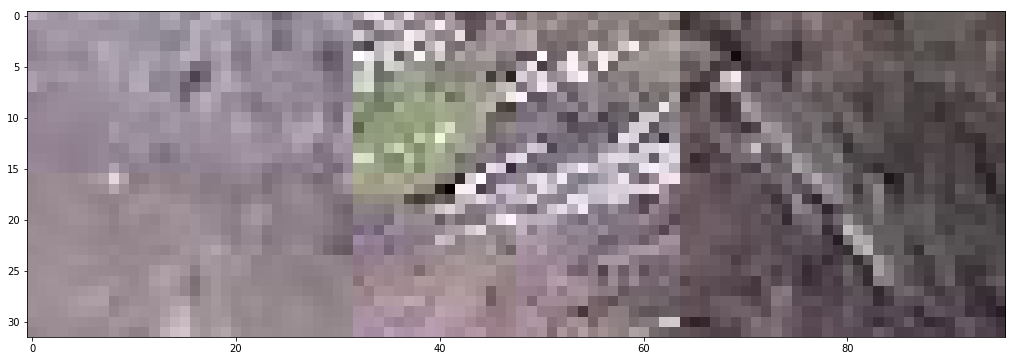

In [5]:
fig = plt.figure(figsize=[18,6])
sample = train.sample(3)
paths = [image_path(s) for s in sample['id']]
imgs = [plt.imread(p) for p in paths]
print("Shape:",imgs[0].shape)
print(sample['has_cactus'])
plt.imshow(np.hstack(imgs))

## load data
Load all data and create test and validation set

In [6]:
x_train, x_val, y_train, y_val = train_test_split(train['id'], train['has_cactus'], test_size=0.1)

In [7]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(15750,) (15750,)
(1750,) (1750,)


In [8]:
def load_imgs(img_names, convert="RGB", dtype="float32", path='train'):
    imgs = []
    for name in tqdm(img_names):
        imgs.append(np.array(Image.open(image_path(name, path=path)).convert(convert), dtype=dtype))
    return np.array(imgs)

In [9]:
x_train_arr = load_imgs(x_train)
x_val_arr = load_imgs(x_val)
x_train_arr_bw = load_imgs(x_train, convert='L', dtype='uint8')
x_val_arr_bw = load_imgs(x_val, convert='L', dtype='uint8')
print(x_train_arr.shape, x_val_arr.shape)
print(x_train_arr_bw.shape, x_val_arr_bw.shape)

100%|██████████| 1750/1750 [00:00<00:00, 4717.60it/s]

(15750, 32, 32, 3) (1750, 32, 32, 3)
(15750, 32, 32) (1750, 32, 32)


## Naive model
make histogram of number of black/white pixels and classify

13780    1
7839     1
5900     0
Name: has_cactus, dtype: int64


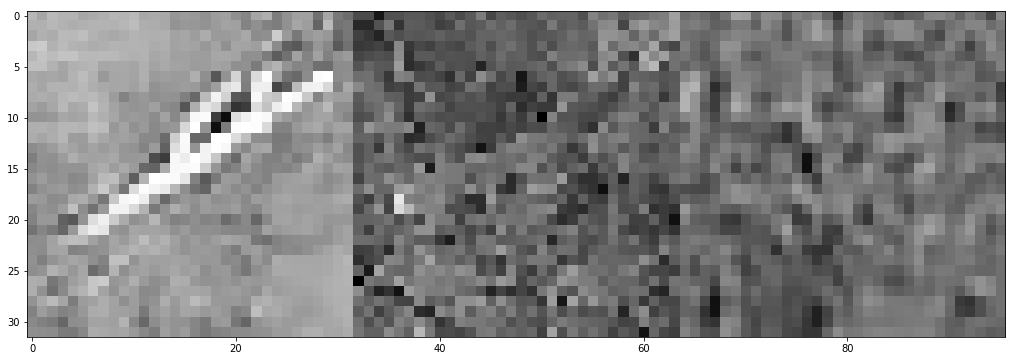

In [10]:
fig = plt.figure(figsize=[18,6])
plt.imshow(np.hstack(x_train_arr_bw[10:13]), cmap='gray')
print(y_train[10:13])

In [11]:
x_train_hist = np.array([np.histogram(r, 256, density=False)[0] for r in x_train_arr_bw])
x_val_hist = np.array([np.histogram(r, 256, density=False)[0] for r in x_val_arr_bw])

/home/shm/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


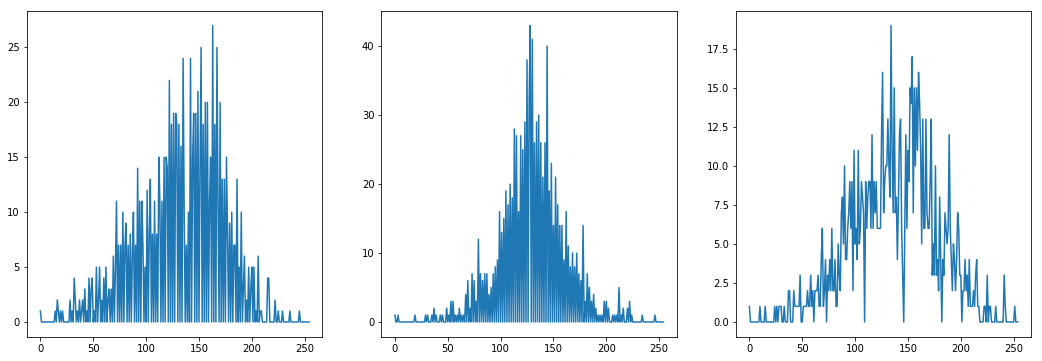

In [12]:
def plot(imgs):
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        plt.plot(img)
        
fig = plt.figure(figsize=[18,6])
plot([x_train_hist[0][:-1], x_train_hist[1][:-1], x_train_hist[2][:-1]])
fig.show()

Ratio of 'has_cactus' in validation set is 0.66. So if we just guess has cactus every time we would have 0.66 accuracy! Every subsequent model should be at least be better than that.

In [13]:
print(y_val.value_counts())
print(1 - y_val.value_counts()[0] / y_val.value_counts()[1])

1    1333
0     417
Name: has_cactus, dtype: int64
0.687171792948237


### RandomForest Classifier

In [14]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
%time rfc.fit(x_train_hist, y_train)
rfc.score(x_val_hist, y_val)

CPU times: user 3min 7s, sys: 332 ms, total: 3min 7s
Wall time: 8.76 s


0.9011428571428571

### SVM

In [15]:
#clf = svm.SVC(gamma=0.001)
#%time clf.fit(x_train_hist, y_train)
#clf.score(x_val_hist, y_val)

## CNN model

In [16]:
from tensorflow.python.keras.layers import Conv2D, Input, Dense, Flatten, Dropout, BatchNormalization, Activation, Dropout, concatenate, Lambda
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.applications.densenet import DenseNet201
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.python.keras.optimizers import Adam

In [17]:
pixel_mean = np.mean(x_train_arr, axis=(0, -3, -2))

In [18]:
def block(inp, size, dropout=0.5):
    x = Dense(size)(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    return x

DENSE_NET_TRAINABLE = True

def preproc(x):
    """ Normalization images"""
    return (x - pixel_mean)[:, :, :, ::-1]
preproc_layer = Lambda(preproc)

inp = Input((32, 32, 3))
dense_net = DenseNet201(include_top=False, input_tensor=preproc_layer(inp))

for layer in dense_net.layers:
    layer.trainable = DENSE_NET_TRAINABLE
    
x = Flatten()(dense_net.output)
#x = block(x, 512)
x = block(x, 256)
#x = block(x, 128, 0.3)
x = Dense(1, activation='sigmoid')(x)

model_name = f'model-1-{DENSE_NET_TRAINABLE}'
model = Model(inp, x, name=model_name)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (

In [19]:
lr = 0.0001

opt = Adam(lr=lr)
model.compile(opt, loss = "binary_crossentropy", metrics=["accuracy"])

### Training

In [1]:
epochs = 30
batch_size = 128

dirs = ['./results', './results/checkpoints', './results/tensorboard']
for d in dirs:
    if not os.path.isdir(d):
        os.mkdir(d)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    vertical_flip=True,
    horizontal_flip=True,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.01,
    zoom_range=[0.9, 1.25],  
    fill_mode='reflect',
)

train_datagen.fit(x_train_arr)


h = model.fit_generator(
    train_datagen.flow(x_train_arr, y_train, batch_size=batch_size),
    steps_per_epoch=x_train_arr.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_val_arr, y_val),
    callbacks=callbacks
)
callbacks = [ReduceLROnPlateau(verbose=1),
             ModelCheckpoint(f'./results/checkpoints/{model_name}.hdf5', save_best_only=True, monitor='val_acc'),
             EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=25, mode='max'),
             TensorBoard(f'./results/tensorboard/{model_name}')]

model.fit(x_train_arr, y_train, batch_size=batch_size, epochs=epochs,
          validation_data=(x_val_arr, y_val),
          callbacks=callbacks)


NameError: name 'os' is not defined

In [19]:
model = load_model('./results/checkpoints/model-1-True.hdf5')

In [20]:
%time val_pred = model.predict(x_val_arr)
print("roc_score", roc_auc_score(np.round(val_pred), y_val))

test = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
test.head()
test_arr = load_imgs(test['id'], path='test')
print(test_arr.shape)

  6%|▌         | 233/4000 [00:00<00:01, 2328.78it/s]

CPU times: user 11.7 s, sys: 492 ms, total: 12.1 s
Wall time: 12 s
roc_score 1.0


100%|██████████| 4000/4000 [00:00<00:00, 4198.37it/s]

(4000, 32, 32, 3)


In [21]:
test_pred = model.predict(test_arr, verbose= 1)
test['has_cactus'] = test_pred
test.head()

4000/4000 [==============================] - 6s 1ms/step


id    has_cactus
0  000940378805c44108d287872b2f04ce.jpg  9.994501e-01
1  0017242f54ececa4512b4d7937d1e21e.jpg  9.994729e-01
2  001ee6d8564003107853118ab87df407.jpg  4.522481e-21
3  002e175c3c1e060769475f52182583d0.jpg  4.244795e-04
4  0036e44a7e8f7218e9bc7bf8137e4943.jpg  9.988956e-01

In [22]:
test.to_csv('submission.csv', index=False)

In [23]:
preds = model.predict(x_val_arr)

7.37772e-05 1
0.9992187 0
0.9994759 0
0.9993493 0
0.00024700808 1
0.999311 0
0.9869833 0
2.104455e-08 1
0.9991628 0
9
(0, 2)
(3, 5)
(6, 8)
(96, 96, 3)


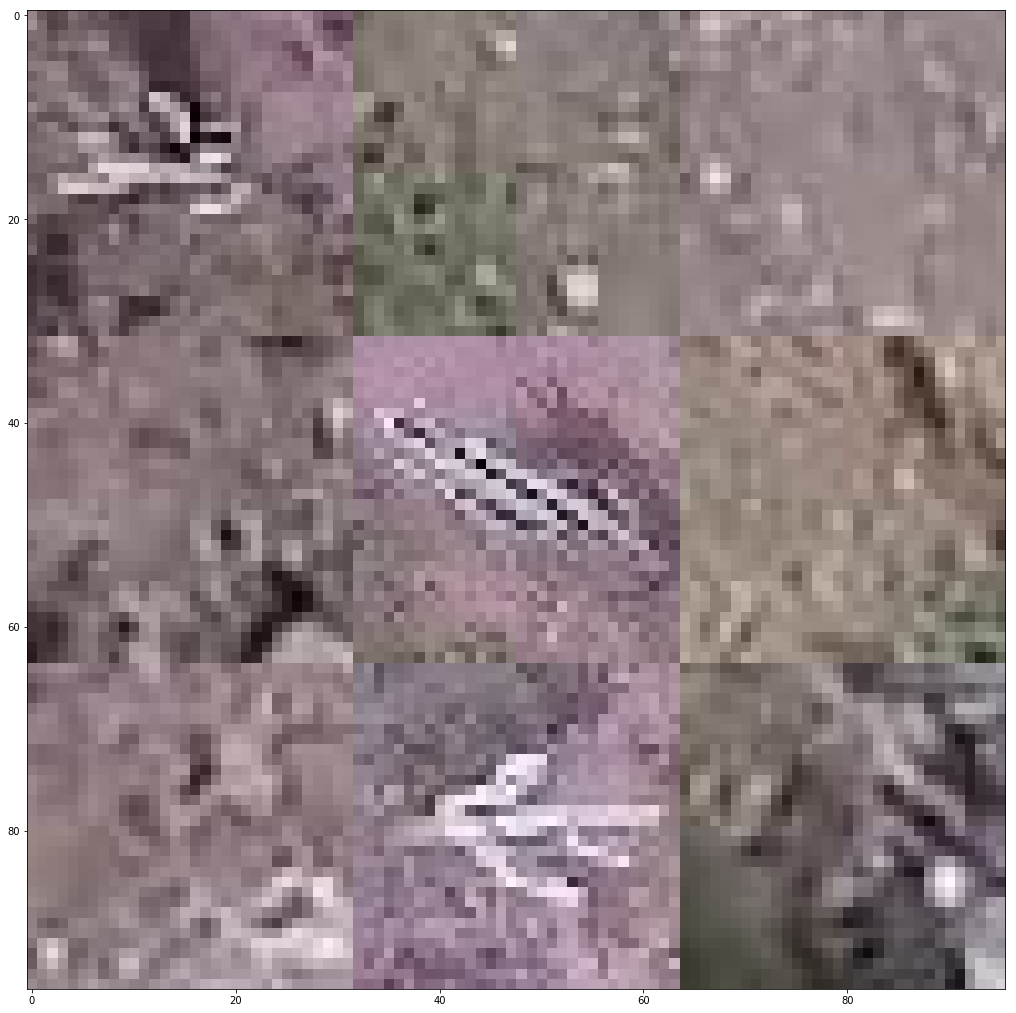

In [24]:
names = []
rpreds = np.round(preds)
for rp, pred, actual, name in zip(rpreds, preds, y_train, x_train):
    if int(rp[0]) != actual:
        print(pred[0], actual)
        names.append(name)
    if len(names) >= 9: break

names = np.array(names)
print(len(names))

x = []
for i in range(3): 
    r = (i * 3, i * 3 +2)
    print(r)
    x.append(np.hstack([plt.imread(image_path(img)) for img in names[r[0]:r[1] + 1]]))

x = np.vstack(x)
print(x.shape)
fig = plt.figure(figsize=[18,18])
plt.imshow(x)

In [21]:
def block(inp, size, dropout=0.5):
    x = Dense(size)(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    return x

DENSE_NET_TRAINABLE = True


inp1 = Input((32, 32, 3))
inp2 = Input((256,))
dense_net = DenseNet201(include_top=False, input_tensor=inp1)

for layer in dense_net.layers:
    layer.trainable = DENSE_NET_TRAINABLE
    
x = Flatten()(dense_net.output)
x = concatenate([x, inp2])
x = block(x, 512)
x = block(x, 256)
#x = block(x, 128, 0.3)
x = Dense(1, activation='sigmoid')(x)

model_name = f'model-2-bw-{DENSE_NET_TRAINABLE}'
model = Model([inp1, inp2], x, name=model_name)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv5_block19_0_bn (BatchNormal (None, 1, 1, 1472)   5888        conv5_block18_concat[0][0]       
__________________________________________________________________________________________________
conv5_block19_0_relu (Activatio (None, 1, 1, 1472)   0           conv5_block19_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block19_1_conv (Conv2D)   (None, 1, 1, 128)    188416      conv5_block19_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block19_1_bn (BatchNormal (None, 1, 1, 128)    512         conv5_block19_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block19_1_relu (Activatio (None, 1, 1, 128)    0           conv5_block19_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

In [22]:
lr = 0.0001
opt = Adam(lr=lr)
#Best rmsprop
model.compile(opt, loss = "binary_crossentropy", metrics=["accuracy"])
#model.compile('adam', loss = "binary_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 30
batch_size = 16

dirs = ['./results', './results/checkpoints', './results/tensorboard']
for d in dirs:
    if not os.path.isdir(d):
        os.mkdir(d)

        
        
def createGenerator(X, I, Y):

    while True:
        # suffled indices    
        idx = np.random.permutation( X.shape[0])
        # create image generator
        
        datagen = ImageDataGenerator(rotation_range=15,
                                     vertical_flip=True,
                                     horizontal_flip=True,
                                     width_shift_range=0.1, 
                                     height_shift_range=0.1, 
                                     shear_range=0.01,
                                     zoom_range=[0.9, 1.25],  
                                     fill_mode='reflect')
        
        batches = datagen.flow(X[idx], Y[idx], batch_size=64, shuffle=False)
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], I[ idx[ idx0:idx1 ] ]], batch[1]

            idx0 = idx1
            if idx1 >= X.shape[0]:
                break
                
                
    
callbacks = [ReduceLROnPlateau(verbose=1),
             ModelCheckpoint(f'./results/checkpoints/{model_name}.hdf5', save_best_only=True, monitor='val_acc'),
             EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=25, mode='max'),
             TensorBoard(f'./results/tensorboard/{model_name}')]


train_gen = createGenerator(x_train_arr, x_train_hist, y_train)
val_gen = createGenerator(x_val_arr, x_val_hist, y_val)

h = model.fit_generator(train_gen,
    #train_datagen.flow(x_train_arr, y_train, batch_size=batch_size),
    steps_per_epoch=x_train_arr.shape[0] // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=x_val_arr.shape[0] // batch_size,                    
    callbacks=callbacks
)

# print(x_train_hist.shape)
# model.fit([x_train_arr, x_train_hist], y_train, batch_size=batch_size, epochs=epochs,
#           validation_data=([x_val_arr, x_val_hist], y_val),
#           callbacks=callbacks)


Epoch 1/30
984/984 [==============================] - 613s 623ms/step - loss: nan - acc: 0.2246 - val_loss: nan - val_acc: 0.0285
Epoch 2/30
455/984 [============>.................] - ETA: 2:45 - loss: nan - acc: 0.2242

In [20]:
?model.fit_generator